In [12]:
import torch
import cv2
import torchvision.transforms as transforms
from torchvision.models import resnet50
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import os
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input

In [30]:
# 2. Load and Preprocess the Image
image_path = '/content/drive/MyDrive/HAM10000/bkl/ISIC_0024453.jpg'
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array = preprocess_input(image_array)

# 3. Feature Extraction with DenseNet121 (using GPU)
with tf.device('/device:GPU:0'):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    output = base_model.layers[-1].output
    output = Flatten()(output)
    model = Model(inputs=base_model.input, outputs=output)
    features = model.predict(image_array)

# 4. Load Your TFLite Model
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/final_model.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
if np.array_equal(input_shape, [1, 224, 224, 3]):  # Compare arrays element-wise
  # Reshape features to original image dimensions and add batch dimension
  features = features.reshape(1, 224, 224, 1)  # Reshape to (1, 224, 224, 1)
  features = np.repeat(features, 3, axis=-1)  # Repeat to (1, 224, 224, 3)
else:
  features = features.reshape(input_shape)  # Reshape to the expected shape


# 6. Make Predictions (potentially using GPU delegate if supported)
# Check if the TFLite interpreter supports GPU delegate
# (refer to TFLite documentation for delegate usage)
# ... your code to set up delegate if supported ...

interpreter.set_tensor(input_details[0]['index'], features.astype(np.float32))
interpreter.invoke()
predictions = interpreter.get_tensor(output_details[0]['index'])

# 7. Process Predictions (e.g., get class labels, probabilities)
# ... your code to interpret the predictions ...
# 7. Process Predictions and Get Class Name
# --- Class Labels and Descriptions ---
class_labels = [
    'Actinic keratoses and intraepithelial carcinoma',
    'basal cell carcinoma',
    'benign keratosis-like lesions',
    'dermatofibroma ',
    'melanoma',
    'melanocytic nevi',
    'vascular lesions'
]

# Add descriptions for each class
class_descriptions = [
    "This is a precancerous skin condition that can develop into skin cancer if not treated.",
    "This is a type of skin cancer that originates in the basal cells, which are located in the lower part of the epidermis.",
    "These are noncancerous skin growths that may resemble warts or skin tags.",
    "This is a common, benign skin growth that usually appears as a firm, red or brown bump.",
    "This is a type of skin cancer that develops from melanocytes, the cells that produce melanin.",
    "These are commonly known as moles and are benign growths of melanocytes.",
    "These are abnormalities of the blood vessels in the skin, such as cherry angiomas or spider veins."
]

# --- Get Predicted Class and Description ---
predicted_class_index = np.argmax(predictions)
predicted_class_name = class_labels[predicted_class_index]
predicted_class_description = class_descriptions[predicted_class_index]

print("Predicted Class Name:", predicted_class_name)
print("Description:", predicted_class_description)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted Class Name: vascular lesions
Description: These are abnormalities of the blood vessels in the skin, such as cherry angiomas or spider veins.


## GradCam

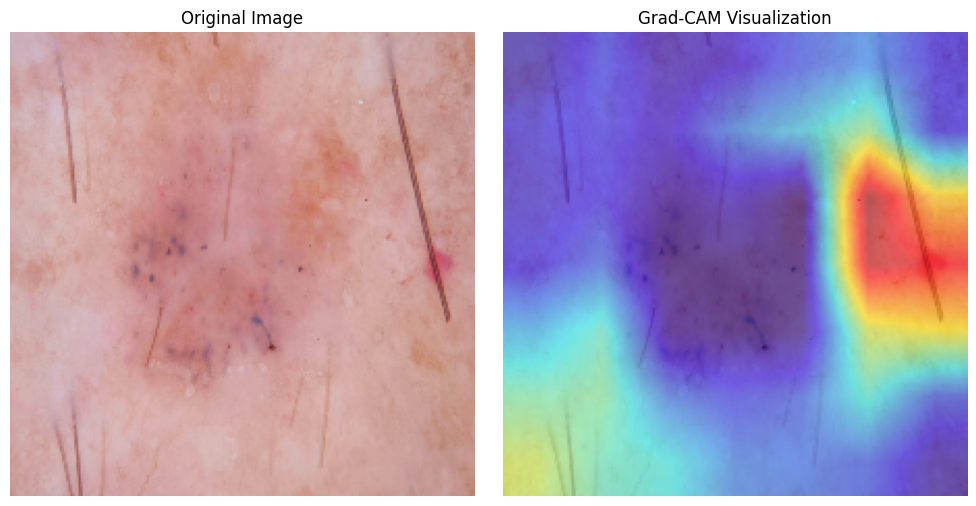

True

In [ ]:
# Step 1: Load the pretrained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50(pretrained=True).to(device)
model.eval()

# Step 2: Specify the target layer for Grad-CAM
target_layers = [model.layer4[-1]]

# Step 3: Load and preprocess the input image
image_path = "/content/drive/MyDrive/HAM10000/per_classes/bcc/ISIC_0024331.jpg"  # Replace with your image path
rgb_img = cv2.imread(image_path, 1)  # Read as BGR
rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)  # Convert to RGB
rgb_img = cv2.resize(rgb_img, (224, 224))  # Resize to model input size
rgb_img_normalized = rgb_img / 255.0  # Normalize to [0, 1]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Convert image to float32 explicitly
input_tensor = transform(rgb_img_normalized).unsqueeze(0).to(torch.float32).to(device)

# Step 4: Specify the target class (optional)
targets = [ClassifierOutputTarget(2)]  # Replace with the correct class index

# Step 5: Generate the Grad-CAM visualization
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]  # Get the CAM for the first image

    # Visualize the CAM on the original image
    visualization = show_cam_on_image(rgb_img_normalized, grayscale_cam, use_rgb=True)

# Step 6: Display both images side by side using matplotlib
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(rgb_img_normalized)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Visualization")
plt.imshow(visualization)
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Save the visualization
cv2.imwrite("grad_cam_result.jpg", cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR))